# Forecasting Carbon Intensity using SARIMA #

## Importing modules ##

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
import time
import sys, os

# Dictionary to store execution times for each code block
execution_times = {}

## Processing data for monthly carbon intensity ##

In [17]:
start_time = time.time()

df = pd.read_csv('../../data/df_fuel_ckan.csv')
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df_filtered = df[(df['DATETIME'].dt.year < 2025) & (df['DATETIME'].dt.year > 2015)].copy()
df_filtered.set_index('DATETIME', inplace=True)
data_train = df_filtered['CARBON_INTENSITY'].resample('M').mean().dropna()
data_train.head()

execution_times['Data Processing'] = time.time() - start_time

print(f"Data Processing Time: {execution_times['Data Processing']:.4f} seconds")


Data Processing Time: 0.8831 seconds


C:\Users\tianw\AppData\Local\Temp\ipykernel_14016\2136849736.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_train = df_filtered['CARBON_INTENSITY'].resample('M').mean().dropna()


## Fitting a SARIMA model to the data ##

In [18]:
start_time = time.time()

model = pmdarima.auto_arima(
    data_train,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_d=3,
    max_q=3,
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)

execution_times['Model Fitting'] = time.time() - start_time

print(f"\nModel Fitting Time: {execution_times['Model Fitting']:.4f} seconds")



Model Fitting Time: 9.1675 seconds


## Generating and Plotting Forecasts for 2025 ##

c:\Users\tianw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


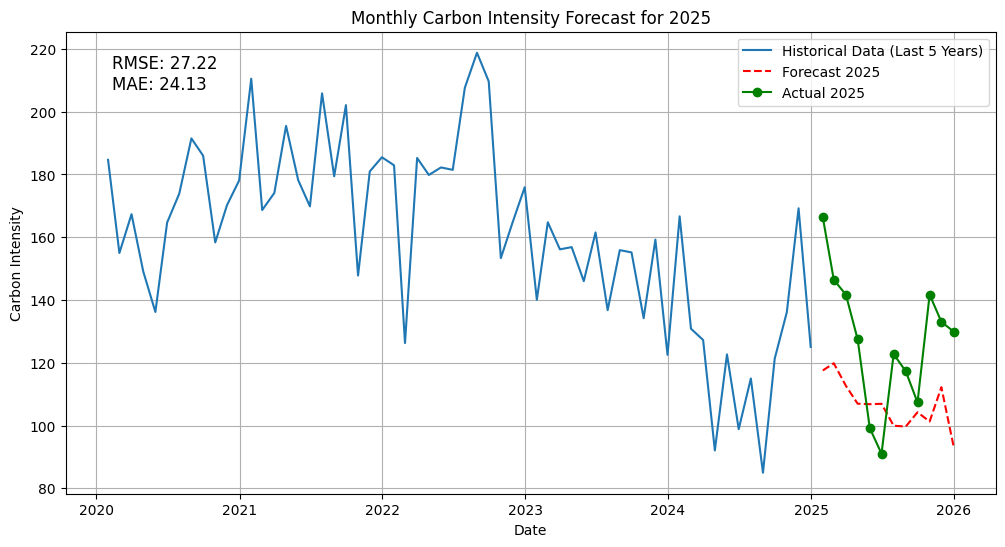


Forecasting and Plotting Time: 0.1706 seconds


In [19]:
start_time = time.time()

# Forecast for 2025 (12 months)
forecast_mean = model.predict(n_periods=12)

# Get actual 2025 data for comparison
df_2025 = df[df['DATETIME'].dt.year == 2025].copy()
df_2025.set_index('DATETIME', inplace=True)
# Handle resampling compatibility
try:
    actual_2025 = df_2025['CARBON_INTENSITY'].resample('ME').mean().dropna()
except ValueError:
    actual_2025 = df_2025['CARBON_INTENSITY'].resample('M').mean().dropna()

RMSE = mean_squared_error(actual_2025, forecast_mean, squared=False)
MAE = mean_absolute_error(actual_2025, forecast_mean)
# Plotting
plt.figure(figsize=(12, 6))

# Plot recent history (last 5 years) for context
history_subset = data_train.tail(60)
plt.plot(history_subset.index, history_subset, label='Historical Data (Last 5 Years)')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast 2025', color='red', linestyle='--')
plt.plot(actual_2025.index, actual_2025, label='Actual 2025', color='green', marker='o')

plt.title('Monthly Carbon Intensity Forecast for 2025')
plt.xlabel('Date')
plt.ylabel('Carbon Intensity')
plt.text(0.05, 0.95, f'RMSE: {RMSE:.2f}\nMAE: {MAE:.2f}', transform=plt.gca().transAxes, va='top', ha='left', fontsize=12)

plt.legend()
plt.grid(True)
plt.show()

execution_times['Forecasting and Plotting'] = time.time() - start_time
print(f"\nForecasting and Plotting Time: {execution_times['Forecasting and Plotting']:.4f} seconds")



### Output the runtime and power usage, etc ###

In [20]:
print("EXECUTION TIME SUMMARY")

for task, duration in execution_times.items():
    print(f"{task}: {duration:.4f} seconds")
print(f"Total Time: {sum(execution_times.values()):.4f} seconds")



EXECUTION TIME SUMMARY
Data Processing: 0.8831 seconds
Model Fitting: 9.1675 seconds
Forecasting and Plotting: 0.1706 seconds
Total Time: 10.2212 seconds
